In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq 
from datetime import datetime

file_path = 'transaction_fraud_data.parquet'

columns_needed = ['amount', 'currency', 'is_fraud', 'timestamp', 'country', 'vendor_category']
transactions = pq.read_table(
    file_path,
    columns=columns_needed,
    filters=[('is_fraud', '==', True)]  # Фильтр мошеннических транзакций
).to_pandas()

# Проверка загруженных данных
print(f"Загружено {len(transactions)} мошеннических транзакций")
print(transactions.head())

Загружено 1494719 мошеннических транзакций
      amount currency  is_fraud                  timestamp  country  \
0    3368.97      BRL      True 2024-09-30 00:00:01.764464   Brazil   
1  724949.27      NGN      True 2024-09-30 00:00:02.544063  Nigeria   
2      11.76      BRL      True 2024-09-30 00:00:03.050458   Brazil   
3   51521.84      MXN      True 2024-09-30 00:00:07.105592   Mexico   
4      36.99      RUB      True 2024-09-30 00:00:10.953172   Russia   

  vendor_category  
0   Entertainment  
1      Healthcare  
2       Education  
3          Retail  
4         Grocery  


In [4]:
# Преобразуем timestamp в datetime
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])
transactions['hour'] = transactions['timestamp'].dt.hour
transactions['day_of_week'] = transactions['timestamp'].dt.dayofweek

# Оптимизация памяти
transactions['is_fraud'] = transactions['is_fraud'].astype(bool)
transactions['currency'] = transactions['currency'].astype('category')
transactions['country'] = transactions['country'].astype('category')
transactions['vendor_category'] = transactions['vendor_category'].astype('category')

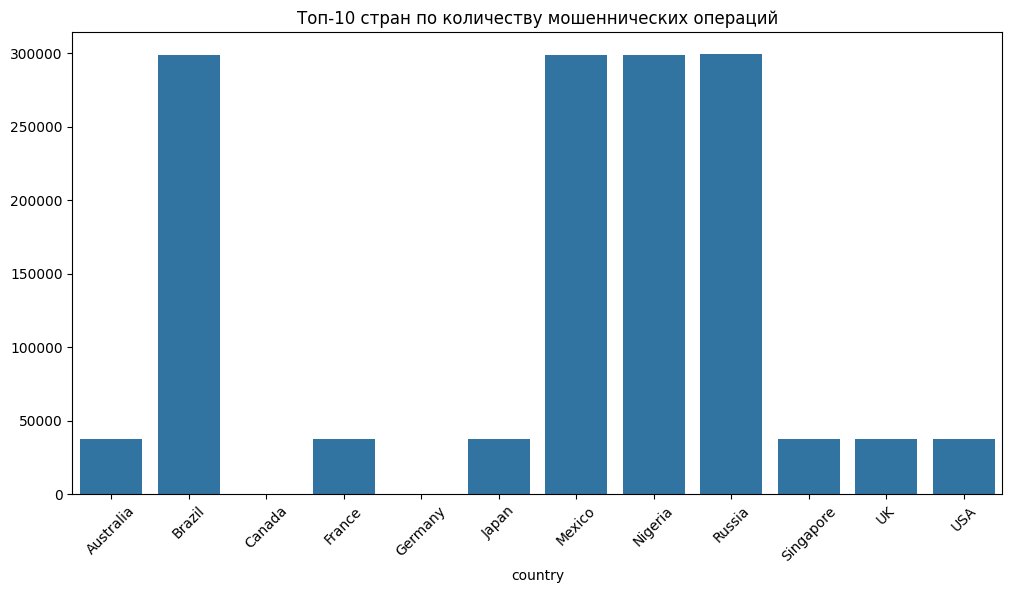

In [5]:
# Распределение мошенничества по странам
plt.figure(figsize=(12, 6))
sns.barplot(x=transactions['country'].value_counts()[:10].index, 
            y=transactions['country'].value_counts()[:10].values)
plt.title('Топ-10 стран по количеству мошеннических операций')
plt.xticks(rotation=45)
plt.show()

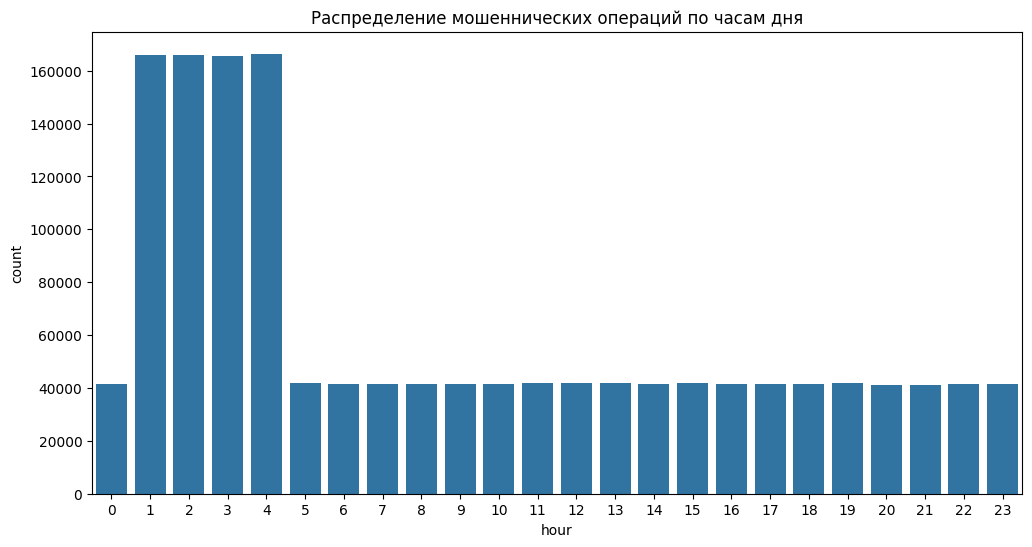

In [6]:
# Мошенничество по часам
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=transactions)
plt.title('Распределение мошеннических операций по часам дня')
plt.show()

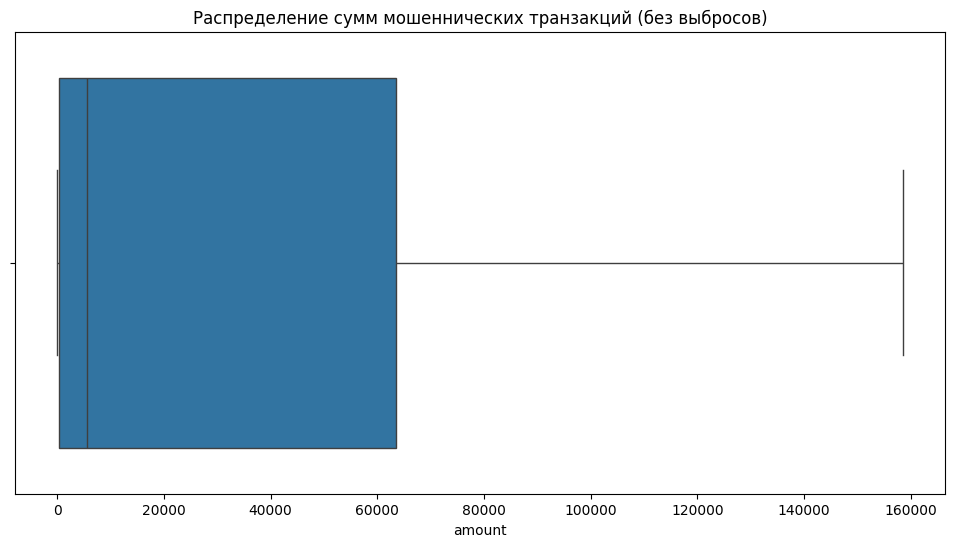

In [7]:
# Боксплот сумм (исключаем выбросы)
plt.figure(figsize=(12, 6))
sns.boxplot(x=transactions['amount'], showfliers=False)
plt.title('Распределение сумм мошеннических транзакций (без выбросов)')
plt.show()

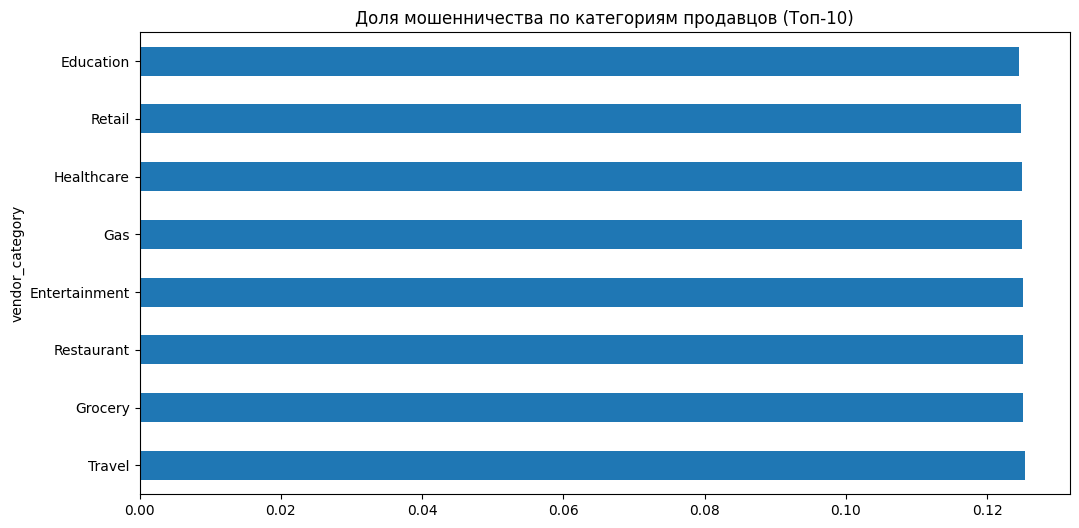

In [8]:
# Доля мошенничества по категориям
plt.figure(figsize=(12, 6))
vendor_fraud = transactions['vendor_category'].value_counts(normalize=True)[:10]
vendor_fraud.plot(kind='barh')
plt.title('Доля мошенничества по категориям продавцов (Топ-10)')
plt.show()

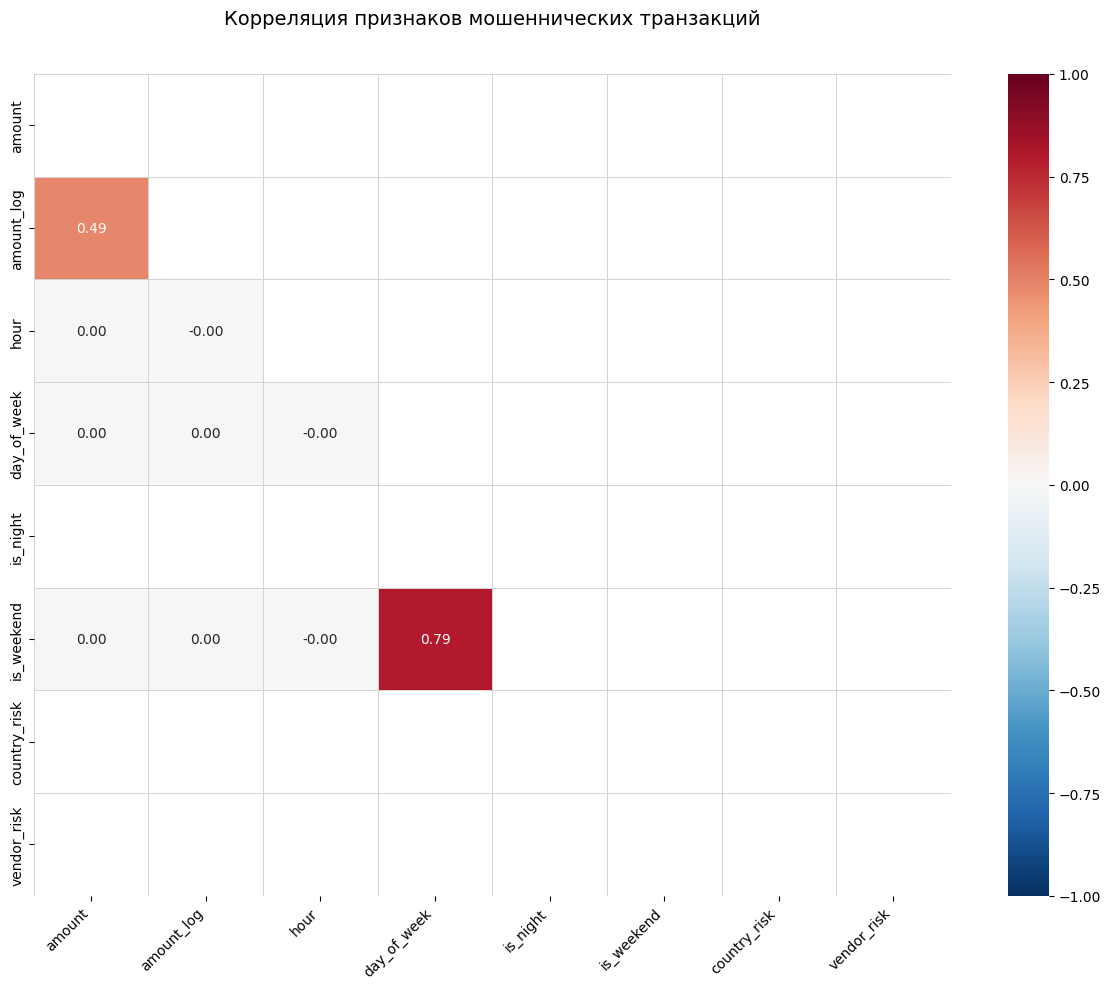

In [16]:
# Убедимся, что все нужные столбцы присутствуют
required_cols = ['amount', 'hour', 'day_of_week', 'country', 'vendor_category', 'is_fraud']
assert all(col in transactions.columns for col in required_cols), "Отсутствуют некоторые необходимые столбцы"

# 1. Создаем производные признаки
transactions['is_night'] = transactions['hour'].apply(lambda x: 1 if 23 <= x <= 5 else 0)
transactions['is_weekend'] = transactions['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
transactions['amount_log'] = np.log1p(transactions['amount'])

# 2. Рассчитываем рискованные категории (с подавлением предупреждений)
with pd.option_context('mode.chained_assignment', None):
    transactions['country_risk'] = transactions['country'].map(
        transactions.groupby('country', observed=True)['is_fraud'].mean()
    ).fillna(0)
    
    transactions['vendor_risk'] = transactions['vendor_category'].map(
        transactions.groupby('vendor_category', observed=True)['is_fraud'].mean()
    ).fillna(0)

# 3. Выбираем финальные признаки для корреляции
numeric_cols = [
    'amount',          # Исходная сумма транзакции
    'amount_log',      # Логарифмированная сумма
    'hour',            # Час проведения операции (0-23)
    'day_of_week',     # День недели (0-6)
    'is_night',        # Ночное время (1/0)
    'is_weekend',      # Выходной день (1/0)
    'country_risk',    # Риск страны (доля мошенничества)
    'vendor_risk'      # Риск категории продавца
]

# 4. Строим матрицу корреляций с улучшенной визуализацией
plt.figure(figsize=(12, 10), dpi=100)
corr_matrix = transactions[numeric_cols].corr()

# Настраиваем тепловую карту
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='lightgray',
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
)

# Добавляем подписи
plt.title('Корреляция признаков мошеннических транзакций\n', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()